### Prepare the data for Machine Learning algorithms

Build robust dataset to solve real-world problems and see how your data preparation ultimately impacts how effective your models are. Additionally, building better features is after data, the second most important way to impact Machine Learning performance. In this part, the dataset is neatly divided into train and test set. What I will do is to deal with missing values and choose right features and their formats for the right algorithms then evaluate their performance, according to the evaluation, tune the features and update this process until no improvement on model performance.


#### 1. Import libraries for data preprocessing

In [ ]:
# import libraries
# Basic operation modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Common Model Helpers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# Machine Learning algorithms
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# Fine tune hyper-parameters
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('Sample_Submission.csv')
cutoff_purchase = np.percentile(train['Purchase'], 99.9)  # 99.9 percentile
train.loc[train['Purchase'] > cutoff_purchase,'Purchase']=cutoff_purchase

The train and test datasets contained 550,068 and 233,599 instances respectively. There are 11 features, four of them are masked and two of them are with missing values.<br>

#### 2.Data cleaning:

• Fill in missing values <br>
In EDA part, we detect that variables 'Product_Category_2' and 'Product_Category_3' both have 31.57%, 69.67%, 30.97% and 69.59% missing values in training set and test set,respectively. Since there are too many missing values in these two features, compared to filling them with other numbers and adding noise to the dataset, I decide to directly drop them. (Further, I actually run the model with these two features and without them, the result shows that RMSE is smaller if dataset does not contain two features. However, I am not sure whether the result will improve a lot if I use other imputation method like building a model instead of filling with subjective numbers.)

In [ ]:
# Concating Train and Test to have feature engineering at the same time
dataset = pd.concat([train,test],ignore_index=True)
data = dataset.copy()

# drop 'Product_Category_2' and  'Product_Category_3' variables since too many missing values
data.drop(['Product_Category_2','Product_Category_3'],inplace=True,axis=1)

#### 3. convert formats

In [4]:
data.head()

,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_ID,Purchase,Stay_In_Current_City_Years,User_ID
0,0-17,A,F,0,10,3,P00069042,8370.0,2,1000001
1,0-17,A,F,0,10,1,P00248942,15200.0,2,1000001
2,0-17,A,F,0,10,12,P00087842,1422.0,2,1000001
3,0-17,A,F,0,10,12,P00085442,1057.0,2,1000001
4,55+,C,M,0,16,8,P00285442,7969.0,4+,1000002



• Five features need to be converted, they include: Product_ID, Gender, Age, City_Category and Stay_In_Current_City_Years. 

**Product_ID **, I first LabelEncoding them directly because I think it seems to have no affect on the model and final scores. However, I was wrong and made mistake here. I trid several different ideas to convert it and decide to drop character 'P' and remain the rest numbers which gives me the best performance. <br>

**Age**, when I explore the dataset I do find that different age groups hold different purchasing patterns. For example, 26-35 age groups are with the greatest purchasing power. Instead of one-hot encoding, I tend to keep the order against purchase amount by mapping the age groups onto specific ages. Modeling result shows that this works and outperforms one-hot encoding way.

**Stay_In_Current_City_Years**, the same situation as age variable, in order to avoid affecting the data patteren or distribution, for example, people stayed 4+ years do not buy too many products compared with those stay 1 year. Rethink about it and I feel like this makes sense that people living here for a long time do need less goods so less shop Black Friday. However, people just move here tend to shop more because they demand more. Consequently, I still map the values to specific years.

**Gender and City_Category** categorical variables are one-hot encoded with pandas function.




In [ ]:
# Convert Product ID to numerical values by removing P and convert the rest part to int type
data["Product_ID"] = data["Product_ID"].str.replace("P", "")
data["Product_ID"] = data["Product_ID"].astype(str).astype(int)

# Map Age variable to specific values
Age_map = {'0-17':17,'26-35':35, '46-50':50, '36-45':45, '18-25':25,'51-55':55,'55+':75}
data['Age'] = data['Age'].map(Age_map)

# Map Stay_In_Current_City_Years variable to specific values
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].map({'0':0,'1':1,'2':2,'3':3,'4+':5})

# Convert Gender and City Category to numerical values using get_dummies function
columns = data.select_dtypes(include=['object']).columns
data=pd.get_dummies(data, columns=columns, prefix=columns)

After converting, features look like following:

In [6]:
data.head()

,Age,Marital_Status,Occupation,Product_Category_1,Product_ID,Purchase,Stay_In_Current_City_Years,User_ID,City_Category_A,City_Category_B,City_Category_C,Gender_F,Gender_M
0,17,0,10,3,69042,8370.0,2,1000001,1,0,0,1,0
1,17,0,10,1,248942,15200.0,2,1000001,1,0,0,1,0
2,17,0,10,12,87842,1422.0,2,1000001,1,0,0,1,0
3,17,0,10,12,85442,1057.0,2,1000001,1,0,0,1,0
4,75,0,16,8,285442,7969.0,5,1000002,0,0,1,0,1


#### 4. Correlation Matrix

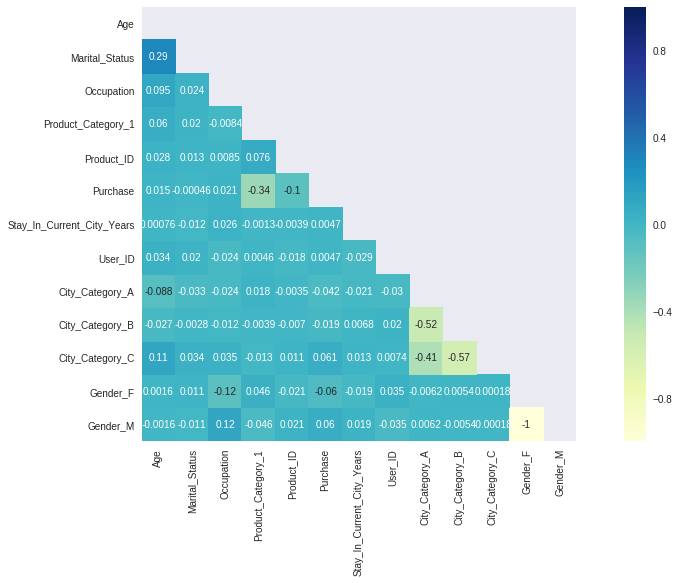

In [7]:
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(17, 8))
ax = sns.heatmap(corr, mask=mask, square = True, vmax = 0.4,annot=True,cmap="YlGnBu")

It is clear and sort of wierd that nothing is highly correlated with the Purchase variable. What I could observe is:

1. Product_ID has a negative correlation with Purchase.
2. Product_Category_1 has a relative strong negative correlation with Purchase.

Since Product_Category_1 variable shows some relation with purchase amount, I think if I have time I may convert it to dummy variable and split each category as a new feature and test the results.

#### 5. Training vs Validation vs Test set

The dataset was already divided into train and test set, so we do not obtain target value for test set. I will split the train set here into training set and validation set to train models and evaluate their performance.

In [ ]:
#Divide into Test and Train again
Train=data.loc[data['Purchase'].isnull()==False]
Test=data.loc[data['Purchase'].isnull()==True]
Test = Test.drop(['Purchase'],axis=1)

# Split into X_train as training set and X_test as validation set
X = Train.drop(['Purchase'], axis=1)
y = Train['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100,test_size=0.3)

In [9]:
print('Test set size:',Test.shape)
print('Train set size:',X_train.shape)
print('Validation set size:',X_test.shape)

Test set size: (233599, 12)
Train set size: (385047, 12)
Validation set size: (165021, 12)


#### 6. Evaluation metric

The contest utilizes the root mean squared error(RMSE) to evaluate the final predictions. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})}$$

where $y_i$ is the ground truth and $\hat{y_i}$ is the prediction for the corresponding test instance.

### Short-List Promising Models

For regression problem, we have a bunch of Machine Learning algorithms as candidates. I plan to train many quick and dirty models from different categories like linear model, SVM, tree model and neural network, etc using standard parameters and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.

In order to train many different models in a reasonable time, I will sample smaller training sets to speed up the process here.

In [ ]:
#Sample smaller training sets
Train_sam = Train.sample(n=round(Train.shape[0]*0.1),random_state=10)
X = Train_sam.drop(['Purchase'], axis=1)
y = Train_sam['Purchase']

#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Test some basic quick and dirty models

In [ ]:
lr_reg = LinearRegression()
lasso = Lasso(random_state=7)
tree = DecisionTreeRegressor(random_state=7)
rf = RandomForestRegressor()

In [12]:
score = rmsle_cv(lr_reg)
print("\nLinear Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear Regression score: 4694.5693 (13.9887)



In [13]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 4694.5706 (13.9981)



In [14]:
score = rmsle_cv(tree)
print("\nDecision Tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Decision Tree score: 3970.0245 (59.9316)



In [15]:
score = rmsle_cv(rf)
print("\nRandom Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest: 2989.9765 (26.4750)



Since Support Vector Regression takes too much time, I do not try it here. It looks tree model is very promising. So I plan to use tree based model to tackle the problem. I am planning to try bagging with base estimator decision tree, random forest, adaboost, gradient boost and extreme gradient boost methods. It's not only because they are able to capture the patterns in the dataset but also some of them provide tools to evaluate the importance of features, which might give us insight for feature engineering.

### Fine-Tune the System

As we all know, finding the optimal parameters is ambitious and time consuming. I started off randomly searching parameters to narrow down the range then moved to grid search to guarantee get more precise result which could be implemented by **GridSearchCV** and **RandomizedSearchCV** sklearn functions. It is wise to use as much data as possible for this step, but fine tuning models really takes long time, considering the convenience of running this kernel, I will use random forest as an example.


**Random Forest**

- Searching parameters randomly helps us narrow down optimal range.

In [16]:
rf = RandomForestRegressor(n_jobs=-1,random_state=10)

param_random = {'n_estimators':range(250,500,100),
               'max_depth':range(25,45,10),
               'min_samples_leaf':range(10,25,5),
               'min_samples_split':range(4,10,4)}

# random search + cross validation
random_rf = RandomizedSearchCV(rf,param_random,cv = 3,scoring='neg_mean_squared_error',n_jobs = -1)
# train model in train set
random_rf.fit(X.values,y.values)
# return search results for each case
result_rf = random_rf.cv_results_
print('Random search results:')
for mean_score, params in zip(result_rf["mean_test_score"], result_rf["params"]):
    print(np.sqrt(-mean_score), params)


Random search results:
2846.0200341577965 {'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_depth': 35}
2846.0189508409844 {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_depth': 35}
2834.60943122496 {'n_estimators': 450, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 35}
2834.594115095639 {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 25}
2839.223371123241 {'n_estimators': 450, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_depth': 25}
2845.7320156595347 {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_depth': 35}
2839.224743594187 {'n_estimators': 450, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_depth': 35}
2835.0217914918367 {'n_estimators': 350, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 25}
2846.022773394435 {'n_estimators': 250, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_depth': 25}
2845.7362413871497 {'n_estima

In [17]:
# get the best estimator
best_rdm_rf = random_rf.best_estimator_
# prediction on validation set
rf_predictions = best_rdm_rf.predict(X_test.values)
mse = mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
print('Best parameters:',random_rf.best_params_)
print('Random Forest with best parameters now, RMSE on validation set:',rmse)

Best parameters: {'n_estimators': 450, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 25}
Random Forest with best parameters now, RMSE on validation set: 2755.296111248655


- Exhaustive grid search over specified parameter values and obtain optimal ones.

In [18]:
## random forest 
rf = RandomForestRegressor(n_jobs=-1,random_state=10)

param_grid = [ { 'n_estimators': [440,460], 
                'max_depth':[24,26,27],
                'min_samples_leaf':[8,12], 
                'min_samples_split':[3,5]}]

## Grid search + cross validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
## Train model in smaller sample set to save running time here
grid_search_rf.fit(X.values, y.values)
## Return search values for each case
cvres_rf = grid_search_rf.cv_results_
print('Grid search results:')
for mean_score, params in zip(cvres_rf["mean_test_score"], cvres_rf["params"]): 
    print(np.sqrt(-mean_score), params)

Grid search results:
2812.277616456983 {'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 440}
2812.2875253141938 {'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 460}
2812.277616456983 {'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 440}
2812.2875253141938 {'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 460}
2814.97950088473 {'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 440}
2814.9111658616084 {'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 3, 'n_estimators': 460}
2814.9795008847304 {'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 440}
2814.9111658616084 {'max_depth': 24, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 460}
2812.390012546474 {'max_depth': 26, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 440}
2812.395357407763 {'max_depth': 26,

In [19]:
# Get the best estimator
best_grd_rf = grid_search_rf.best_estimator_
# Output predictions on validation set
rf_grd_predictions = best_grd_rf.predict(X_test.values)
mse = mean_squared_error(y_test, rf_grd_predictions)
rmse = np.sqrt(mse)
print('Best parameters:',grid_search_rf.best_params_)
print('Random Forest with best parameters now, RMSE on validation set:',rmse)

Best parameters: {'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 440}
Random Forest with best parameters now, RMSE on validation set: 2747.3909738985035


I will use the same idea to tweak the parameters for the rest methods and directly give my optimal parameters for the rest models after extensive tuning.